## Tutorial for running cNMF on the 10X PBMC dataset used in the [SEURAT](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html) and [SCANPY](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorials.

We use scanpy for the basic filtering and plotting of the cNMF results so see [their documentation](https://scanpy-tutorials.readthedocs.io/en/latest/index.html#) for more details on that.

 - Current as of February 14 2022
 - Email dkotliar@broadinstitute.org with questions
 

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
from cnmf import cNMF

if not os.path.exists('example_PBMC'):
    os.mkdir('example_PBMC')
    
np.random.seed(14)

## Download the data and copy it to the directory ./example_PBMC

In [2]:
! wget -O example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
! tar -zxvf example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz    
! mv filtered_gene_bc_matrices example_PBMC
! rm  example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz

--2022-02-15 19:27:51--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2022-02-15 19:27:51--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: “example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz”

100%[======================================>] 7,621,991   43.0M/s   in 0.2s    

2022-02-15 19:27:52 (43.0 MB/s) - “example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz” saved [7621991/7621991]

filtered_g

## Load the dataset as a sparse matrix into the Scanpy structure and then filter genes that aren't observed in  at least 3 cells, and cells with fewer than 200 genes detected

In [3]:
adata = sc.read_10x_mtx(
    'example_PBMC/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',
    cache=False)

adata.var_names_make_unique()

In [4]:
## Loaded data of 2700 PBMCs with 32738 genes
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [5]:
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells


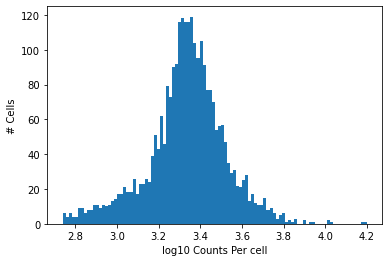

In [6]:
## plot log10 # counts per cell
plt.hist(np.log10(adata.obs['n_counts']), bins=100)
_ = plt.xlabel('log10 Counts Per cell')
_ = plt.ylabel('# Cells')

## Save the scanpy object to a file. This file will be passed as input to cNMF

In [7]:
count_adat_fn = 'example_PBMC/counts.h5ad'
sc.write(count_adat_fn, adata)

## You can also pass a text file containing the counts matrix to cNMF. The 2 cells below illustrate the format of such a file (cell x genes) with a row index containing the cell identifier and the columns containing the gene_symbols. And how you could save such it.

## These steps can be skipped for the rest of the tutorial

In [8]:
dense_data = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index).astype(int)
dense_data.head()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
AAACATACAACCAC-1,0,0,0,0,0,0,0,0,0,0,...,0,10,1,0,4,0,0,0,0,0
AAACATTGAGCTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,33,1,0,8,0,1,0,0,0
AAACATTGATCAGC-1,0,0,0,0,0,0,0,0,0,0,...,0,3,2,0,4,0,0,0,0,0
AAACCGTGCTTCCG-1,0,0,0,0,0,0,0,0,0,0,...,1,3,2,0,2,0,0,0,0,0
AAACCGTGTATGCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0


In [9]:
## Commented out because it is slow

count_txt_fn = 'example_PBMC/counts.tsv'
#dense_data.to_csv(count_txt_fn, sep='\t')

## In the cells below, we run the first 2 steps of cNMF assuming no parallelization:
    - prepare - normalizes the data for the run and specifies the input parameters
    - factorize - runs the actual factorization steps.
    
## With the options below, this took roughly 4 minutes on our compute configuration. To speed this up on your own runs, you can run it only for K=7-8 as those are the only Ks we look in detail at in the steps below. See the commented out K variable in the below cell

In [10]:
numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=2000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = 'example_PBMC/cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
K = ' '.join([str(i) for i in range(5,11)])

## To speed this up, you can run it for only K=7-8 with the option below
#K = ' '.join([str(i) for i in range(7,9)])


seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'example_PBMC/counts.h5ad'

In [11]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [12]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
cnmf_obj.prepare(counts_fn=countfn, components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=1)

[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 113.
[Worker 0]. Starting task 114.
[Worker 0]. Starting task 115.
[Worker 0]. Starting task 116.
[Worker 0]. Starting task 117.
[Worker 0]. Starting task 118.
[Worker 0]. Starting task 119.


## These same steps could alternatively have been run from the command line using the cnmf command line script like below

In [14]:
cmd = 'cnmf prepare --output-dir example_PBMC/cNMF --name pbmc_cNMF -c example_PBMC/counts.h5ad -k 5 6 7 8 9 10 --n-iter 20 --total-workers 1 --seed 14 --numgenes 2000 --beta-loss frobenius'
print('Command line - prepare step: %s' % cmd)
!{cmd}

Command line - prepare step: cnmf prepare --output-dir example_PBMC/cNMF --name pbmc_cNMF -c example_PBMC/counts.h5ad -k 5 6 7 8 9 10 --n-iter 20 --total-workers 1 --seed 14 --numgenes 2000 --beta-loss frobenius
/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
cmd = 'cnmf factorize --output-dir example_PBMC/cNMF --name pbmc_cNMF --worker-index 0'
print('Command line - factorize step: %s' % cmd)
!{cmd}

Command line - factorize step: cnmf factorize --output-dir example_PBMC/cNMF --name pbmc_cNMF --worker-index 0
[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.

## Alternatively, you could run cNMF with parallel processing. We illustrate commands for this using GNU parallel (which parallelizes over multiple CPUs on a machine) and with UGER (which parallelizes over multiple nodes on a compute cluster

First the prepare step is run as before but specifying numworkers to be equal to the number of CPUs or compute nodes you want to distribute over.

On a ubuntu-like system you can test how many cpus are on the machine with the lscpu command

In [16]:
## Using GNU parallel
## This took 4 minutes in our testing
numworkers = 4
factorize_cmd = 'nohup parallel python ../cnmf.py factorize --output-dir example_PBMC/cNMF --name pbmc_cNMF --worker-index {} ::: 0 1 2 3'
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (numworkers, factorize_cmd))
#!{factorize_cmd}

Factorize command to simultaneously run factorization over 4 cores using GNU parallel:
nohup parallel python ../cnmf.py factorize --output-dir example_PBMC/cNMF --name pbmc_cNMF --worker-index {} ::: 0 1 2 3


## Alternatively, if you have access to an UGER scheduler system, you could run the factorization command like below which schedules the tasks of 1 worker to each compute node assuming only a single processor per node

In [17]:
## Using UGER
logdir = '.'
uger_factorize_cmd = "qsub -cwd -b y -l h_vmem=2g,h_rt=3:00:00 -o . -e . -N cnmf -t 1-4 'python ./cnmf.py factorize --output-dir example_PBMC/cNMF --name pbmc_cNMF --worker-index $SGE_TASK_ID'"
print('Factorize command to simultaneously run factorization over %d nodes of a compute cluster using UGER:\n%s' % (numworkers, uger_factorize_cmd))
#!{cmd}

Factorize command to simultaneously run factorization over 4 nodes of a compute cluster using UGER:
qsub -cwd -b y -l h_vmem=2g,h_rt=3:00:00 -o . -e . -N cnmf -t 1-4 'python ./cnmf.py factorize --output-dir example_PBMC/cNMF --name pbmc_cNMF --worker-index $SGE_TASK_ID'


## Whether or not you used parallelization in the above steps, you should resume here with the combine step below which combines the individual factorization replicates so that the consensus estimate can be taken

In [18]:
cnmf_obj.combine()

Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.


In [19]:
## Or again you can use the command line
cmd = 'cnmf combine --output-dir example_PBMC/cNMF --name pbmc_cNMF'
print('Command line - combine step: %s' % cmd)
!{cmd}

Command line - combine step: cnmf combine --output-dir example_PBMC/cNMF --name pbmc_cNMF
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.


## Compute the stability and error at each choice of K to see if a clear choice jumps out.

Please note that the maximum stability solution is not always the best choice depending on the application. However it is often a good starting point even if you have to investigate several choices of K

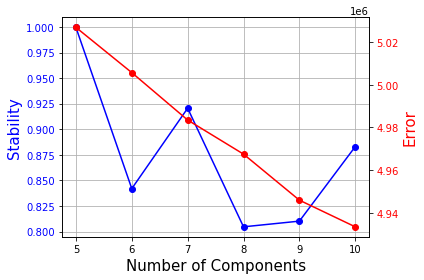

In [20]:
cnmf_obj.k_selection_plot(close_fig=False)

In [21]:
print('This saves the corresponding figure to the following file: %s' % cnmf_obj.paths['k_selection_plot'])

This saves the corresponding figure to the following file: example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.k_selection.png


You can also run the command from the command line like below

In [22]:
kselect_plot_cmd = 'cnmf k_selection_plot --output-dir example_PBMC/cNMF --name pbmc_cNMF'
print('K selection plot command: %s' % kselect_plot_cmd)
#!{kselect_plot_cmd}

K selection plot command: cnmf k_selection_plot --output-dir example_PBMC/cNMF --name pbmc_cNMF


## In this range, K=7 gave the most stable solution so we will begin by looking at that.

The next step computes the consensus solution for a given choice of K. We first run it without any outlier filtering to see what that looks like. Setting the density threshold to anything >= 2.00 (the maximum possible distance between two unit vectors) ensures that nothing will be filtered.

Then we run the consensus with a filter for outliers determined based on inspecting the histogram of distances between components and their nearest neighbors

In [23]:
selected_K = 7
density_threshold = 2.00

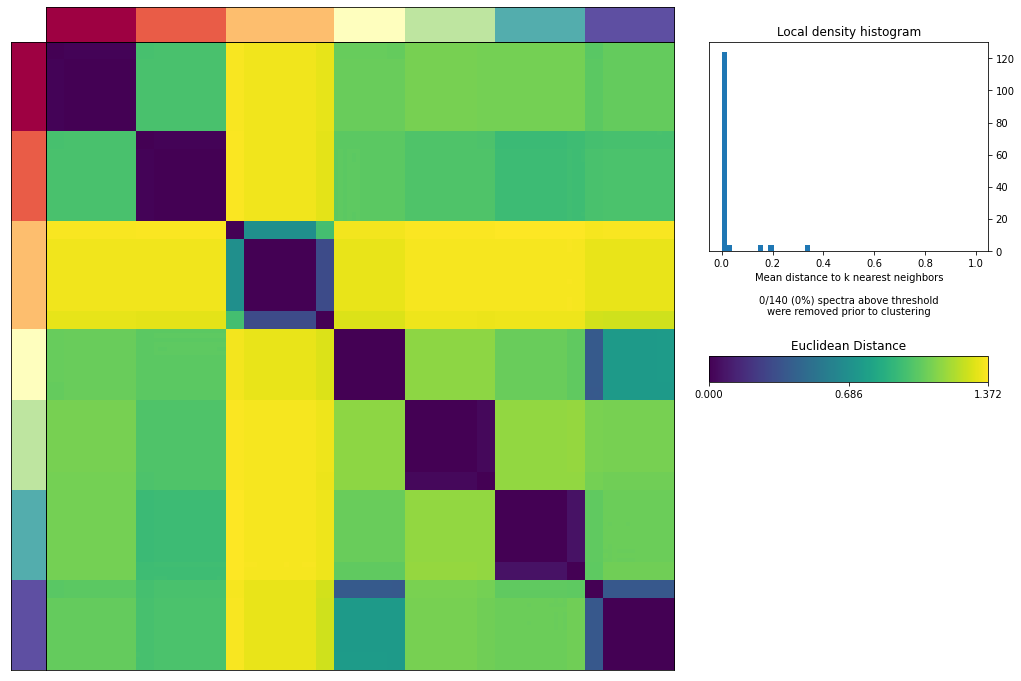

In [24]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

The output figure was saved to ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.clustering.k_7.dt_0_1.png so you can find it there if you ran the consensus step from the command line

The above consensus plot shows that there is a substantial degree of concordance between the replicates with a few outliers. An outlier threshold of 0.1 seems appropriate

In [25]:
density_threshold = 0.10

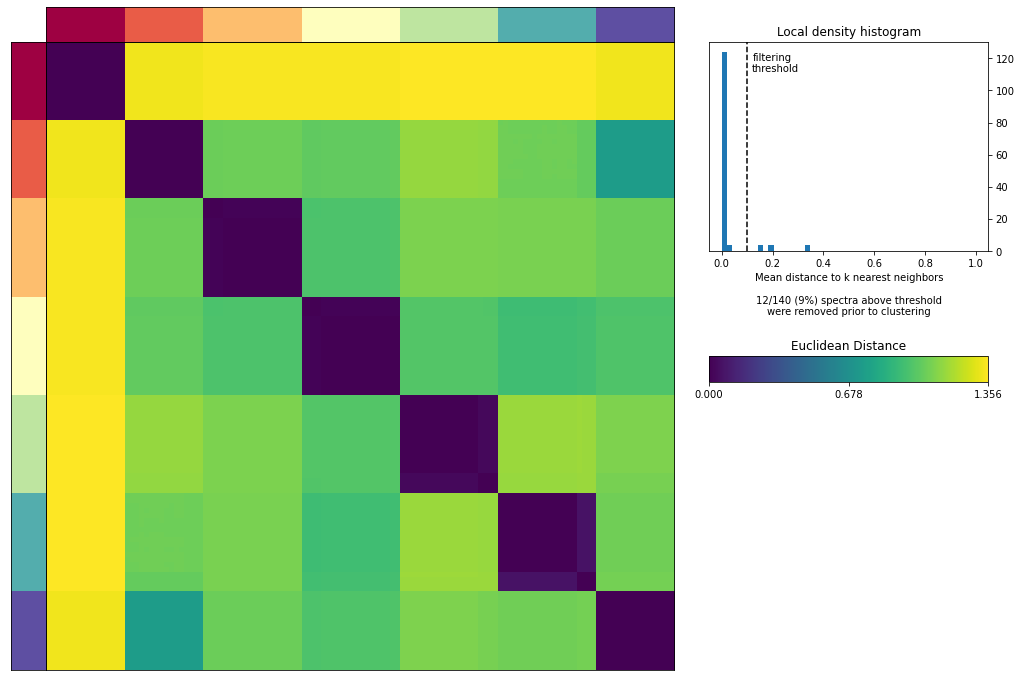

In [26]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

## Now that we have completed the consensus step for cNMF, a number of output files have been outputted to look at

In [27]:
! ls ./example_PBMC/cNMF/pbmc_cNMF

cnmf_tmp
pbmc_cNMF.clustering.k_7.dt_0_1.png
pbmc_cNMF.clustering.k_7.dt_2_0.png
pbmc_cNMF.gene_spectra_score.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_score.k_7.dt_2_0.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_2_0.txt
pbmc_cNMF.k_selection.png
pbmc_cNMF.k_selection_stats.df.npz
pbmc_cNMF.overdispersed_genes.txt
pbmc_cNMF.spectra.k_7.dt_0_1.consensus.txt
pbmc_cNMF.spectra.k_7.dt_2_0.consensus.txt
pbmc_cNMF.usages.k_7.dt_0_1.consensus.txt
pbmc_cNMF.usages.k_7.dt_2_0.consensus.txt


We are most interested in the usage and gene_spectra_score files for the density threshold of 0.1:
  - ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.gene_spectra_score.k_7.dt_0_10.txt
  - ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.usages.k_7.dt_0_10.consensus.txt
    
Below, we load those in as text files, append them to a processed Scanpy AnnData object so we can make plots of how the usages overlap with UMAP dimensionality reudctions of the data
    

## The steps below load the AnnData object, TPT normalize it, mean and variance normalize each gene, run PCA, and run UMAP. We use the same set of high-variance genes that were determined prior to running cNMF which we obtain as the columns of the raw output file:

 - ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.spectra.k_7.dt_0_10.consensus.txt

In [28]:
adata = sc.read(countfn)

In [29]:
## Obtain high variance genes that were used for cNMF as these were saved to a text file
hvgs = open('./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.overdispersed_genes.txt').read().split('\n')

In [30]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4) ## TPT normalization

In [31]:
## Set log-normalized data to the raw attribute of the AnnData object to make it easy to plot expression levels of individual genes.
## This does not log normalize the actual AnnData data matrix
adata.raw = sc.pp.log1p(adata.copy(), copy=True)

In [32]:
## Subset out only the high-variance genes

adata = adata[:,hvgs]

In [33]:
## Mean and variance normalize the genes

sc.pp.scale(adata)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
## Run PCA

sc.pp.pca(adata)

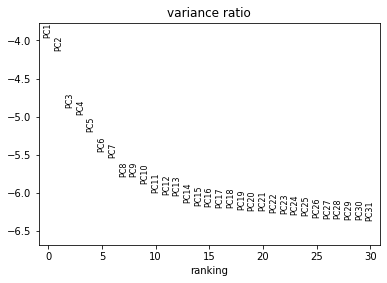

In [35]:
## Make a scree plot to determine number of PCs to use for UMAP

sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
## Construct the nearest neighbor graph for UMAP

sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)

In [37]:
## Run UMAP

sc.tl.umap(adata)

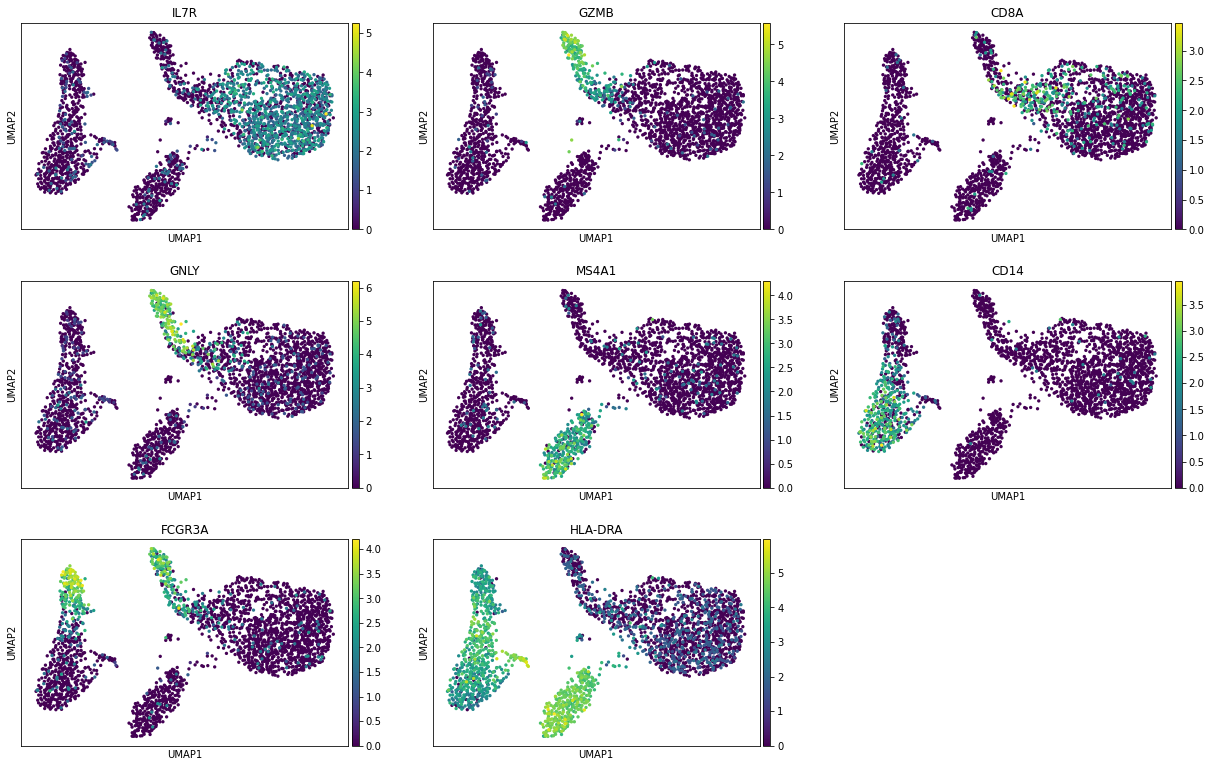

In [38]:
## Plot the UMAP with some cannonical marker genes to see that the apparent grouping makes sense

sc.pl.umap(adata, color=['IL7R', 'GZMB', 'CD8A','GNLY',
                         'MS4A1', 'CD14', 'FCGR3A', 'HLA-DRA'],
           use_raw=True, ncols=3)

## First we load the raw usage file that was output by cNMF. cNMF does not normalize the usages to sum to 1 for each cell so we do that as a subsequent step in the second cell below

In [39]:
usage_file = cnmf_obj.paths['consensus_usages__txt'] % (selected_K, '0_1')
print(usage_file)

example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.usages.k_7.dt_0_1.consensus.txt


In [40]:
usage = pd.read_csv(usage_file, sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7
AAACATACAACCAC-1,0.000000,2.481752,33.135577,323.236945,17.165929,0.000000,0.000000
AAACATTGAGCTAC-1,0.000000,0.000000,63.007540,222.952710,29.510167,423.356955,30.506136
AAACATTGATCAGC-1,6.307095,3.960529,44.016264,449.745154,14.414914,0.000000,33.938026
AAACCGTGCTTCCG-1,11.843357,162.244084,31.248600,17.806739,6.996068,45.263203,230.149738
AAACCGTGTATGCG-1,0.219488,38.548343,9.443272,24.795727,161.718475,15.212312,0.000000


In [41]:
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7
AAACATACAACCAC-1,0.000000,0.006600,0.088122,0.859627,0.045652,0.000000,0.000000
AAACATTGAGCTAC-1,0.000000,0.000000,0.081899,0.289800,0.038358,0.550291,0.039653
AAACATTGATCAGC-1,0.011418,0.007170,0.079684,0.814192,0.026096,0.000000,0.061439
AAACCGTGCTTCCG-1,0.023427,0.320925,0.061811,0.035222,0.013838,0.089532,0.455245
AAACCGTGTATGCG-1,0.000878,0.154232,0.037783,0.099208,0.647035,0.060864,0.000000


In [42]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

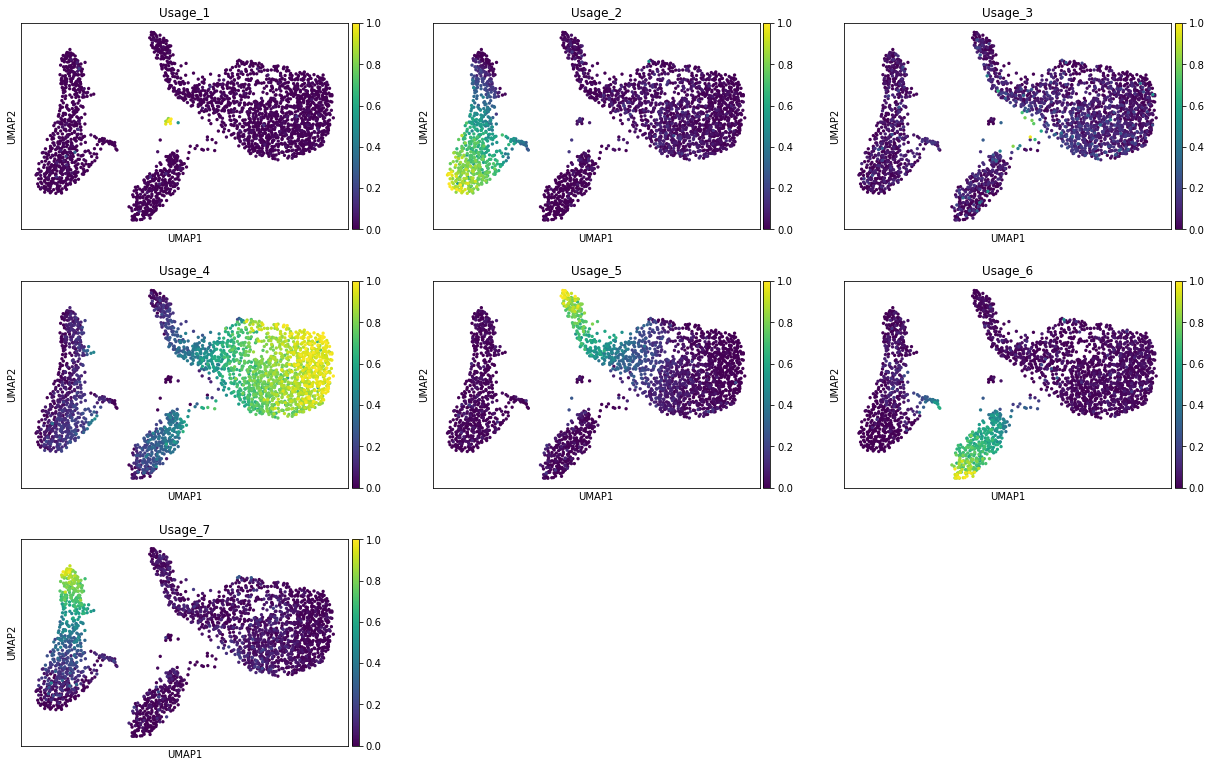

In [43]:
sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=1)

## The usages roughly overlap with the expression of marker genes in the plots above:
 - 2 - CD14+ monocyte identity
 - 4 - CD4 T-cell identity
 - 5 - NK/CD8 T-cell identity 
 - 6 - B-cell identity
 - 7 CD16+ monocyte identity
 
## What is a bit less clear is the interpretation of GEP 1 and 3. Lets load in the gene_scores and identify the genes that are most associated with each program to see if we can interpret them.

In [44]:
selected_K = 7

In [45]:
gene_scores_file = cnmf_obj.paths['gene_spectra_score__txt'] % (selected_K, '0_1')
print(gene_scores_file)

example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.gene_spectra_score.k_7.dt_0_1.txt


In [46]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = pd.read_csv(gene_scores_file, sep='\t', index_col=0).T
gene_scores.head()

,1,2,3,4,5,6,7
AL627309.1,-0.000019,0.000582,-0.000024,-0.000065,-0.000026,-0.000315,-0.000220
AP006222.2,0.000002,0.000114,-0.000046,0.000025,-0.000008,-0.000138,-0.000026
RP11-206L10.2,-0.000023,-0.000047,-0.000039,-0.000054,-0.000153,0.000990,-0.000104
RP11-206L10.9,-0.000055,0.000556,-0.000022,-0.000130,-0.000117,-0.000080,0.000162
LINC00115,-0.000055,0.000025,-0.000024,-0.000053,0.000207,0.000053,0.000017


In [47]:
## Obtain the top 40 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = []
ngenes = 40
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

,1,2,3,4,5,6,7
0,C2orf88,LYZ,RRM2,RPS12,NKG7,CD74,FCGR3A
1,TSC22D1,S100A9,CDC6,RPS27,PRF1,HLA-DRA,FCER1G
2,HIST1H2AC,S100A8,MCM10,RPS25,GZMB,HLA-DQB1,LST1
3,AC147651.3,CST3,TYMS,EEF1A1,GZMA,HLA-DQA1,RP11-290F20.3
4,LGALSL,CD14,KIAA0101,RPS15A,GNLY,HLA-DPB1,MS4A7
5,ACRBP,FCN1,CDC20,RPL31,FGFBP2,HLA-DRB1,IFITM3
6,PTCRA,TYROBP,TK1,RPS6,SPON2,CD79B,IFITM2
7,MMD,LGALS2,KIFC1,RPS27A,CST7,HLA-DQA2,COTL1
8,ESAM,GSTP1,BIRC5,RPLP2,CTSW,MS4A1,RHOC
9,PRUNE,LGALS1,BLM,RPS3A,CLIC3,HLA-DPA1,AIF1


## The top expressed genes for GEP 3 include common cell cycle markers such as MKI67 but also plasmablast genes such as MZB1

## GEP 1 is a bit more complicated but includes high expression of genes like [MMD](https://www.ncbi.nlm.nih.gov/gene/23531) (MMD monocyte to macrophage differentiation associated) and [ESAM](https://www.ncbi.nlm.nih.gov/gene/90952) (Endothelial cell adhesion molecule) suggesting that is may reflect a distinct stage of monocyte differentiation

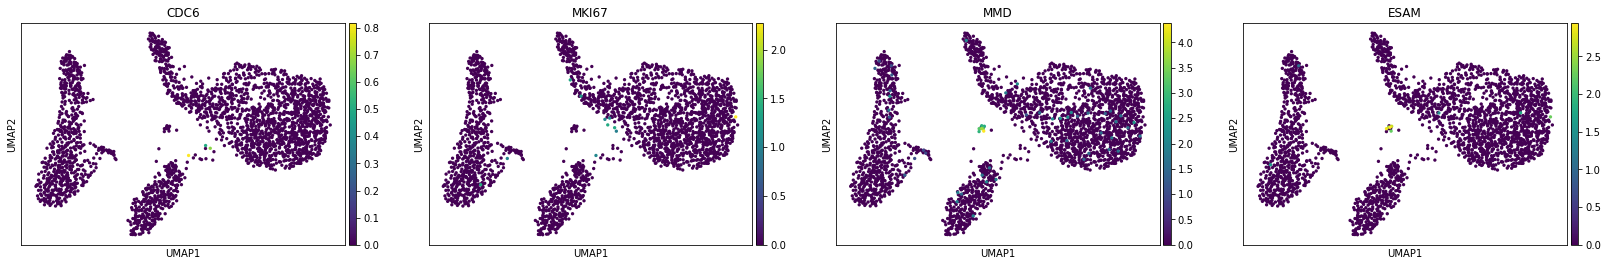

In [48]:
sc.pl.umap(adata, color=['CDC6', 'MKI67', 'MMD', 'ESAM'],
           use_raw=True, ncols=4)

## Let us quickly investigate a larger value of K to see if there are other less robust GEPs that may be worth exploring further, potentially with larger numbers of NMF replicates

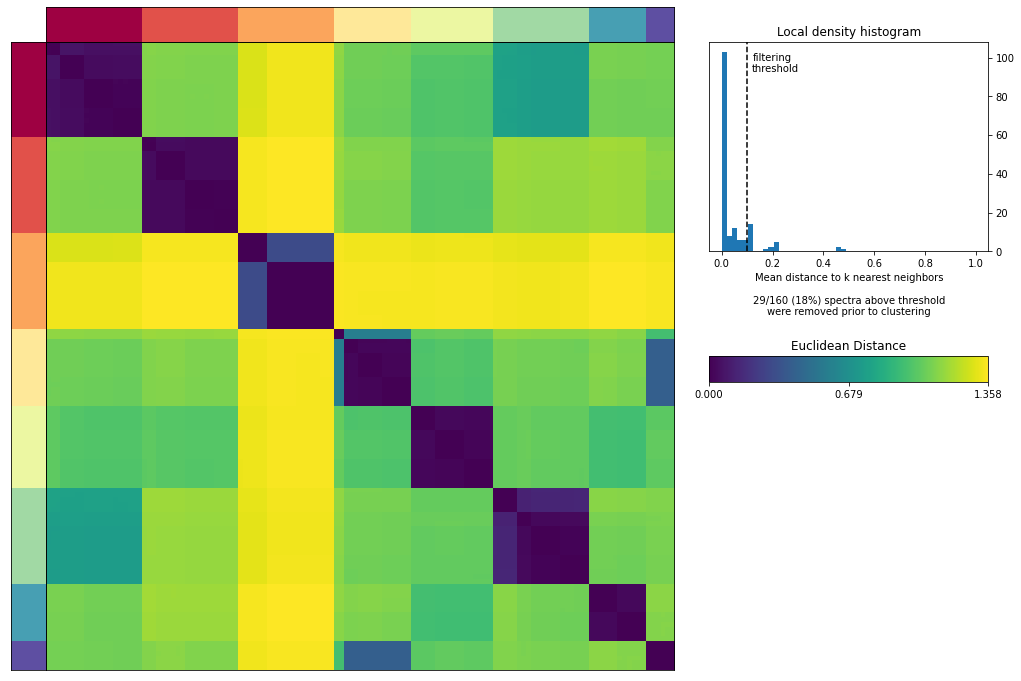

In [49]:
cnmf_obj.consensus(k=8, density_threshold=0.1, show_clustering=True, close_clustergram_fig=False)

We might want to use a slightly higher density threshold based on the histogram which shows some programs that aren't outliers are getting cut off

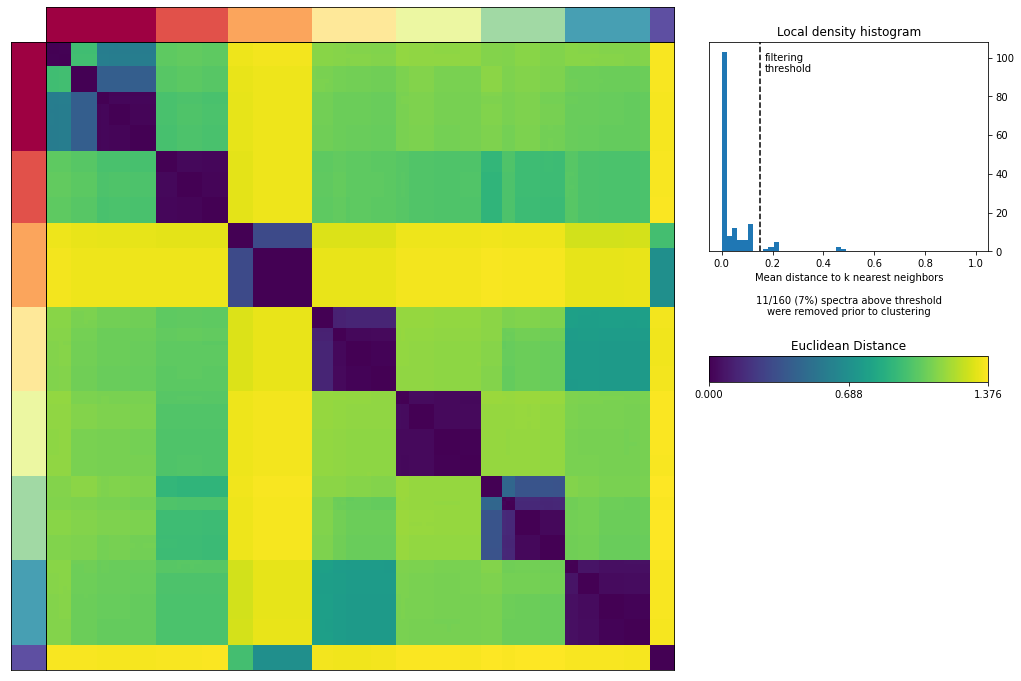

In [50]:
cnmf_obj.consensus(k=8, density_threshold=0.15, show_clustering=True, close_clustergram_fig=False)

That looks a bit better

## AS expected, there is considerably more variability in the solutions of distinct NMF replicates with this run. Thus more caution must be taken in interpreting the results, and ideally cNMF should be run with a larger number of replicates

## It seems that in some iterations the 3rd GEP is getting split into 2 components, while in other iterations, it is being kept as a single one

## Lets look at the resulting programs

In [51]:
usage_file = cnmf_obj.paths['consensus_usages__txt'] % (8, '0_15')
print(usage_file)

example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.usages.k_8.dt_0_15.consensus.txt


In [52]:
usage = pd.read_csv(usage_file, sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8
AAACATACAACCAC-1,33.906460,321.672237,0.000000,2.967849,17.283541,0.000000,0.000000,0.000000
AAACATTGAGCTAC-1,68.940944,217.613277,0.000000,0.000000,30.864361,419.437209,32.238984,0.000000
AAACATTGATCAGC-1,44.448677,448.389152,0.000000,3.921649,14.204750,0.000000,34.698183,7.082710
AAACCGTGCTTCCG-1,32.157173,18.014835,0.000000,159.164436,6.325557,44.972501,231.266800,17.240425
AAACCGTGTATGCG-1,10.217411,24.087354,0.281506,38.627126,161.488667,15.403062,0.000000,0.000000


In [53]:
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8
AAACATACAACCAC-1,0.090218,0.855898,0.000000,0.007897,0.045988,0.000000,0.000000,0.000000
AAACATTGAGCTAC-1,0.089639,0.282947,0.000000,0.000000,0.040131,0.545365,0.041918,0.000000
AAACATTGATCAGC-1,0.080414,0.811204,0.000000,0.007095,0.025699,0.000000,0.062774,0.012814
AAACCGTGCTTCCG-1,0.063160,0.035383,0.000000,0.312613,0.012424,0.088330,0.454229,0.033862
AAACCGTGTATGCG-1,0.040852,0.096309,0.001126,0.154444,0.645683,0.061586,0.000000,0.000000


In [54]:
# Remove the old usages from the AnnData object
adata.obs = adata.obs.drop([x for x in adata.obs.columns if 'Usage_' in x], axis=1)

In [55]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

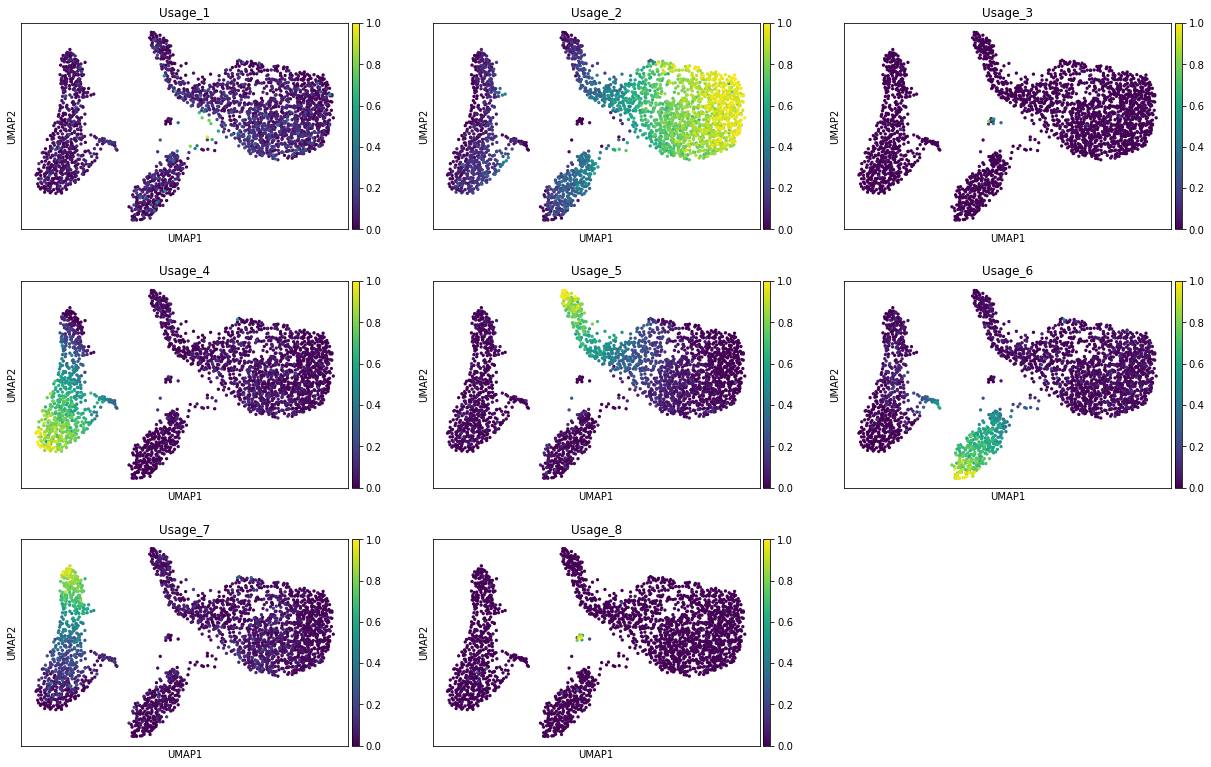

In [56]:
sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=1)

In [57]:
gene_scores_file = cnmf_obj.paths['gene_spectra_score__txt'] % (8, '0_15')
print(gene_scores_file)

example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.gene_spectra_score.k_8.dt_0_15.txt


In [58]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = pd.read_csv(gene_scores_file, sep='\t', index_col=0).T
gene_scores.head()


,1,2,3,4,5,6,7,8
AL627309.1,-0.000022,-0.000066,0.000019,0.000586,-0.000026,-0.000318,-0.000223,-0.000102
AP006222.2,-0.000048,0.000026,0.000037,0.000117,-0.000008,-0.000139,-0.000028,-0.000105
RP11-206L10.2,-0.000045,-0.000054,0.000003,-0.000044,-0.000151,0.000999,-0.000106,-0.000110
RP11-206L10.9,-0.000022,-0.000131,-0.000030,0.000561,-0.000117,-0.000080,0.000160,-0.000134
LINC00115,-0.000020,-0.000054,-0.000025,0.000026,0.000208,0.000054,0.000015,-0.000111


In [59]:
## Obtain the top 40 genes for each GEP in sorted order and combine them into a single dataframe


top_genes = []
ngenes = 50
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes.head(20)

,1,2,3,4,5,6,7,8
0,RRM2,RPS12,C2orf88,LYZ,NKG7,CD74,FCGR3A,PF4
1,CDC6,RPS27,PRUNE,S100A9,PRF1,HLA-DRA,FCER1G,SDPR
2,MCM10,RPS25,AATK,S100A8,GZMB,HLA-DQB1,LST1,GNG11
3,TYMS,EEF1A1,GNAZ,CD14,GZMA,HLA-DQA1,RP11-290F20.3,HIST1H2AC
4,KIAA0101,RPS15A,SMOX,CST3,GNLY,HLA-DPB1,MS4A7,CLU
5,CDC20,RPL31,FAM212B,FCN1,FGFBP2,HLA-DRB1,IFITM3,LY6G6F
6,TK1,RPS6,ESAM,TYROBP,SPON2,CD79B,IFITM2,SPARC
7,KIFC1,RPS27A,FRMD3,LGALS2,CST7,MS4A1,COTL1,PPBP
8,BIRC5,RPLP2,TSC22D1,GSTP1,CTSW,HLA-DQA2,RHOC,TUBB1
9,BLM,RPL23A,TMCC2,LGALS1,CLIC3,HLA-DPA1,AIF1,MMD


## We find essentially the same GEPs as before except the order is different and the mysterious myeloid program is split into GEP 3 and GEP 8:

 - 1. cell-cycle activity
 - 2. T-cell identity
 - 3. The mysterious myeloid GEP 1 
 - 4. CD14+ monocyte identity
 - 5. NK cell identity
 - 6. B-cell identity 
 - 7. CD16+ monocyte identity
 - 8. Platelet
 
## Looking more closely at GEP 8, we see some megakaryocyte/platelet lineage markers like [PF4](#https://www.ncbi.nlm.nih.gov/gene/?term=PF4) and [PPBP](https://www.ncbi.nlm.nih.gov/gene/5473) which suggests that a significant fraction of the cells with high usage of that GEP may be megakaryocytes.

## Further exploration would be needed to interpret these programs. A good place to start would be to run cNMF with a larger number of replicates. Additionally, For one could run cNMF or hard-clustering on just the myeloid lineage cells to isolate dendritic cell populations which can be observed on the UMAP as the myeloid branch with higher levels of HLA-DRA. Gene-set enrichment testing could be run using the gene scores as a continuous feature